In [ ]:
# 가상환경 리스트 확인
# conda env list

# 가상환경 만들기
# conda create -n [이름] python=[버전]
# conda activate [이름]

# 가상환경 삭제
# conda deactivate
# conda remove -n [이름] --all

<span style="font-size:12px">

#### CNN - 이미지 분류를 응용한 문서분류
- 데이터 입력 --> 토큰화(문장을 단어화) 및 시퀀스(단어를 숫자화) 변화 --> 패딩 (길이 고정화) 
--> 임베딩 (단어->벡터화(방향)) --> 1D Convolution + poling 반복 --> Flatten --> Dense (은닉층) --> 출력 (softmax, 이진분류) --> 학습 (Adam + binary_crossentropy) --> 검증/테스트 평가 --> 시각화
- 말뭉치 로딩 (nltk) 데이터 로딩
- 토큰화(빈도 기반 인덱싱) 텍스트를 숫자로 변환
- 시퀀스 패딩 : 문자열 길이 고정 배치 구성
- 임베딩 단어를 Dense vector 표현 학습
    - 임베딩 발전
        - 한계 : 작은데이터에서는 일반화 부족
        - 발전 : 사전학습(Word2vec), 문맥적 임베딩(BERT, GPT)

In [ ]:
#### 실습1
# 토큰화
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# sample data
texts = [
    'I really love this movie',
    'I hate this boring film',
    'love love great film'
]

# 토큰화 객체 (최대 단어 10, oov 토큰 지정)
tokenizer = Tokenizer(num_words=10, oov_token='UNK')
tokenizer.fit_on_texts(texts)  # 텍스트 데이터를 학습해서 단어사전(word_index)을 만드는 단계/단어등장 빈도수 계산
print(f'단어인덱스 : {tokenizer.word_index}') # --> 마지막꺼 사용안함 / num_words=10 하면, 실제 사용가능한 단어 인덱스는 1~9까지 (지정숫자 미만인 단어까지 사용함)

# 시퀀스화 : 문장을 숫자로 변경
seqs=tokenizer.texts_to_sequences(texts)
print(f'원본 시퀀스 : {seqs}')

# 패딩 (최대 길이를 6)
padded = pad_sequences(seqs, maxlen=6, padding='post')  #padding='pre'는 앞쪽 자르고, 'post'는 뒤쪽 자름
                    # maxlen=6
                    # 문장(시퀀스)의 최대 길이 (각 문장에 단어 몇개씩 쓸지?)

print(f'패딩결과 : {padded}, 사이즈 : {padded.shape}')

# 임베딩 : tensorflow에 있는 임베딩 레이어 사용
import tensorflow as tf
vocab_size = 11 # 0은 패딩용, 1은 UNK용, 나머지 단어 9개 / ( 계산쉽게.. UNK포함 단어인덱스 최대값 (num_words=10) +1 )
                # vocab_size = 11  → “단어 종류의 개수 (어휘 크기)” : 모델이 몇 개의 고유 단어 인덱스를 다룰 수 있는가 / 사전안에 있는 단어수
                # 임베딩 층의 input_dim에 해당 -> 단어 하나하나를 4차원 벡터로 바꿀 "사전크기"
embed_dim = 4 # 작은차원 (현재에서 최소 차원수준/ 문장수 단어수가 적어서 복잡한 표현 필요없음/ 차원 커질수록 파라미터수가 커지고 과적합 위험)
                # embed_dim	사용 예
                # 2~8	교재 예제, toy dataset
                # 16~64	소규모 감정분석, 영화리뷰
                # 100~300	Word2Vec / GloVe / FastText 등
                # 512~1024+	BERT, GPT 등 대형 언어모델

model= tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
])
embeddings = model.predict(padded)
print(f'임베딩 텐서 모양 : {embeddings.shape}')
    # 출력결과 (3,6,4) --> 3:문장의개수(샘플수) padded행수 / 6: 각 문장의 길이(토큰수, maxlen) / 4는 output_dim=embed_dim=4
print (f'첫 문장 첫 단어 벡터 : {embeddings[0,0,:]}')

단어인덱스 : {'UNK': 1, 'love': 2, 'i': 3, 'this': 4, 'film': 5, 'really': 6, 'movie': 7, 'hate': 8, 'boring': 9, 'great': 10}
원본 시퀀스 : [[3, 6, 2, 4, 7], [3, 8, 4, 9, 5], [2, 2, 1, 5]]
패딩결과 : [[3 6 2 4 7 0]
 [3 8 4 9 5 0]
 [2 2 1 5 0 0]], 사이즈 : (3, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
임베딩 텐서 모양 : (3, 6, 4)
첫 문장 첫 단어 벡터 : [ 0.03027382 -0.0049149  -0.04831417  0.02316846]


In [ ]:
#### 실습1
# 1D convolution 예시
import numpy as np
import tensorflow as tf

# 임의 시퀀스 (배치=1, 길이=6, 임베딩=6)
x = np.random.randn(1,6,4).astype('float32')
conv = tf.keras.layers.Conv1D(
    filters = 2   # 문장에서 2개의 패턴을 감지 ---> 긍정/부정을 감지
    , kernel_size=3 #문장에서 3칸씩 찍어나가므로.. 3-gram
    , activation = 'relu'
)
y = conv(x)
print(f'입력 shape {x.shape} \n출력 shape {y.shape} \n출력값 {y.numpy()}')

입력 shape (1, 6, 4) 
출력 shape (1, 4, 2) 
출력값 [[[0.49980676 0.07543179]
  [0.         0.        ]
  [0.7968437  0.        ]
  [0.9489886  0.        ]]]


<span style="font-size:12px">
----------------------------------------------

1, 6, 4 ---> 1, 4, 2
3개씩 찍어나가므로.. (kernel_size=3) 이렇게 6에서 4개가 됨

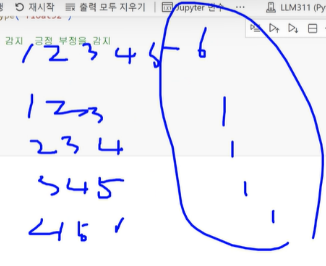



In [ ]:
#### 실습1
# Maxpooling : 절반으로 줄어듬. 1,4,2 --> 1,2,2
pool = tf.keras.layers.MaxPooling1D(pool_size=2)
pooled = pool(y)
print (f'before pooling: {y.shape}  \nafterpooling : {pooled.shape}')

before pooling: (1, 4, 2)  
afterpooling : (1, 2, 2)


In [ ]:
#### 실습1
# 상기내용 합치기
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  #단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences  # 길이 맞추길

texts = [
    'I really love this movie',  #긍정
    'I hate this boring film',  #부정
    'great love movie', #긍정
    'boringf hate film' #부정
]

labels = np.array([0,1,0,1]) #y값에 해당 #긍정 #부정 #긍정 #부정
tokenizer = Tokenizer(num_words=50, oov_token="UNK")
tokenizer.fit_on_texts(texts)  #단어사전 생성 / 반환받지 않음
seqs = tokenizer.texts_to_sequences(texts) # 단어사전기반으로 단어들을 숫자로 변경 (이 단계까지는 길이가 다름)
x = pad_sequences(seqs, maxlen=6, padding= 'post')
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(51, 8, input_length=6),  #51: num_words+1, 8:8차원, input_length=6=maxlen
        tf.keras.layers.Conv1D(16,3,activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x,labels,epochs=15)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc: 0.5000 - loss: 0.6977
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.5000 - loss: 0.6961
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.5000 - loss: 0.6945
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.5000 - loss: 0.6935
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 0.5000 - loss: 0.6925
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.5000 - loss: 0.6915
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - acc: 0.7500 - loss: 0.6905
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - acc: 1.0000 - loss: 0.6896
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - acc: 1.0000 - loss: 0.6889
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 1.0000 - loss: 0.6881
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - acc: 1.0000 - loss: 0.6871
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - acc: 1.0000 - loss: 0.6861
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 1.0000

In [ ]:
#### 실습1
print(f"최종 훈련 정확도 : {history.history['acc'][-1]}")
preds=model.predict(x)
print(f'예측확률 : {preds.reshape(-1)} \n라벨 : {labels}')

최종 훈련 정확도 : 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
예측확률 : [0.49158302 0.50126624 0.48827514 0.50073934] 
라벨 : [0 1 0 1]


In [40]:
### 실습3
# nltk 데이터로드

import nltk
nltk.download('movie_review')
from nltk.corpus import movie_reviews

[nltk_data] Error loading movie_review: Package 'movie_review' not
[nltk_data]     found in index


In [41]:
### 실습3
import numpy as np

# 재현성 시드 고정
import random
SEED  =42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
### 실습3
# 데이터로딩
# 하이퍼파라미터
# 토큰화 + 시퀀스변화 + 패딩
# 라벨인코딩
# train/test 분할
# 모델 구성
# 컴파일
# 콜백 (선택사항)
# 학습 
# 학습결과 시각화
# 테스트 평가
# 임의의 데이터로 예측

In [42]:
### 실습3
# 데이터로딩
ids = movie_reviews.fileids()  #영화리뷰 txt파일
reviews=[movie_reviews.raw(id) for id in ids]
categories =[ movie_reviews.categories(id)[0] for id in ids]
categories[:3], reviews[:3]

(['neg', 'neg', 'neg'],
 ['plot : two teen couples go to a church party , drink and then drive . \nthey get into an accident . \none of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . \nwhat\'s the deal ? \nwatch the movie and " sorta " find out . . . \ncritique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . \nwhich is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn\'t snag this one correctly . \nthey seem to have taken this pretty neat concept , but executed it terribly . \nso what are the problems with the movie ? \nwell , its main problem is that it\'s simply too jumbled . \nit starts off " normal " but then downshifts into this " fantasy " world in which 

In [ ]:
### 실습3
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  #단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences  # 길이 맞추길

# 하이퍼파라미터 :# 최대단어수, 문서길이, 임베딩차원, batch_size, epoch
max_words= 10000 # 최대단어수
maxlen = 500 #문서길이
embed_dim = 64 #임베딩차원
batch_size=256 #batch_size
epochs = 15 #epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words, oov_token="UNK")
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x, maxlen=maxlen, truncating='post')
                                # padding : 길이가 짧을 때 채움 / 앞에서 채울지, 뒤에서 채울지
                                # truncating : 길이가 길때 짜름/ 앞 or 뒤

# 라벨인코딩
label_map = {'pos':0, 'neg':1}
y= np.array([label_map.get(c) for c in categories])

# train/test 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)


# 모델 구성
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_words, output_dim=embed_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPool1D(),  # MaxPpool : 시퀀스의 구간별로 최대값만 출력/시퀀스 구간별 특징을 요약
        tf.keras.layers.Conv1D(256, 3, activation='relu'),
        # tf.keras.layers.GlobalAvgPool1D(),  
                    # GlobalAvgPool1D : 전체시퀀스의 평균 출력 / 시퀀스 차원을 없애고 채널 축만 남김?????(채널에 대한 평균)  --> 데이터가 1차원형태로 펴져서 flatten 할필요없음
        tf.keras.layers.MaxPool1D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
            

# 컴파일
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

# 콜백 (선택사항) (early stopping)
es = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

# 학습 
history = model.fit(
    x_train,y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2
#     , callbacks=[es]
)


# 출력결과
# callbacks (patience=3) 하니까 한 5번 정도 학습하다 early stopping됨
# --> callback 미기재 /또는 / early stopping에서 patience를 크게주고 에포크 늘리기
# 출력결과 
# patience=7 주고, callback 사용 : acc: 0.8930 - loss: 0.4032 - val_acc: 0.6562 - val_loss: 0.6005
# callback 미기재

Epoch 1/15


c:\Users\playdata2\miniconda3\envs\LLM\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 423ms/step - acc: 0.5336 - loss: 0.6982 - val_acc: 0.5437 - val_loss: 0.6901
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - acc: 0.4891 - loss: 0.6949 - val_acc: 0.5437 - val_loss: 0.6925
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - acc: 0.5188 - loss: 0.6923 - val_acc: 0.5188 - val_loss: 0.6926
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - acc: 0.5414 - loss: 0.6909 - val_acc: 0.5562 - val_loss: 0.6903
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - acc: 0.6187 - loss: 0.6893 - val_acc: 0.5188 - val_loss: 0.6900
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - acc: 0.5391 - loss: 0.6868 - val_acc: 0.5188 - val_loss: 0.6919
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - acc: 0.5523 - loss: 0.6811 - val_acc: 0.5250 - val_loss: 0.6906
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - acc: 0.5891 - loss: 0.6714 - val_acc: 0.5281 - val_loss: 0.6892
Epoch 9/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - acc: 0.6570 - loss: 0.6488 - va

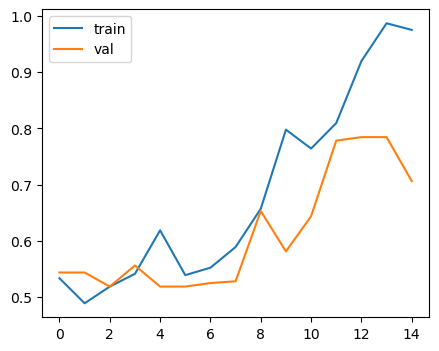

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.6425 - loss: 0.8272
test_loss:0.8271718621253967, test_acc:0.6424999833106995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[0.94982964]
 [0.9657033 ]]
출력결과 안좋음 
==이유 chat-gpt 
1. 과적합 문제 
 - 학습 시 history 그래프에서 train accuracy는 높지만 val accuracy는 낮음 → 과적합 
 - 모델이 train 데이터에서는 잘 맞추지만, 새로운 데이터나 테스트 데이터에서는 성능이 떨어짐 
2. 모델 구조 
 - Conv1D + MaxPool1D 구조는 간단하지만, 시퀀스 길이(maxlen=500)에 비해 학습량이 부족할 수 있음 
 - 데이터가 충분히 많지 않다면 feature extraction이 어려움 
3. 하이퍼파라미터 
 - Epoch 15, batch_size 256 정도는 괜찮지만, learning rate나 embedding_dim, Conv1D 필터 수 등이 최적이 아닐 수 있음


In [13]:
### 실습3
# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 상기 출력결과... 시간이 지날수록 train 과 val의 차이가 커짐 --> 과적합 커짐

# 테스트 평가
test_loss, test_acc=model.evaluate(x_test,y_test)
print (f'test_loss:{test_loss}, test_acc:{test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]

## 임의의 데이터 시퀀스 변화
x_temp_test = tokenizer.texts_to_sequences(sample_texts)
x_temp_test = pad_sequences(x_temp_test, maxlen=maxlen, truncating='post')
temp_preds = model.predict(x_temp_test)
print(temp_preds)
# 출력결과 : [[0.5750105]  [0.5424737]]  label_map = {'pos':0, 'neg':1}
print('출력결과 안좋음 \
\n==이유 chat-gpt \
\n1. 과적합 문제 \
\n - 학습 시 history 그래프에서 train accuracy는 높지만 val accuracy는 낮음 → 과적합 \
\n - 모델이 train 데이터에서는 잘 맞추지만, 새로운 데이터나 테스트 데이터에서는 성능이 떨어짐 \
\n2. 모델 구조 \
\n - Conv1D + MaxPool1D 구조는 간단하지만, 시퀀스 길이(maxlen=500)에 비해 학습량이 부족할 수 있음 \
\n - 데이터가 충분히 많지 않다면 feature extraction이 어려움 \
\n3. 하이퍼파라미터 \
\n - Epoch 15, batch_size 256 정도는 괜찮지만, learning rate나 embedding_dim, Conv1D 필터 수 등이 최적이 아닐 수 있음')



In [ ]:
### 실습3 에서 모델 부분 관련 사항 추가 설명
### 예제 : Falatten 과 GlobalAvgPool1D 비교

x=tf.random.normal((32,10,64)) # conv1D -- 통과 --->  배치크기, 시퀀스길이, 채널수 가 나옴
tf.keras.layers.Flatten()(x)
print(tf.keras.layers.Flatten()(x).shape)  # ---> (32, 640) --> 채널이 커져서 과적합위험?
print(tf.keras.layers.GlobalAvgPool1D()(x).shape) # ---> (32, 640)--> 각 채널 feature map 마다 평균

(32, 640)
(32, 64)


학습된 모델을 추론해서 결과 보기

개선 아이디어
    GlobalMaxPooling 사용(Flatten 대신) → 파라미터 감소
    다중 커널 크기(3,5,7) 병렬 적용 (TextCNN 구조)
    Pretrained Embeddings (GloVe) 로 초기화
    과적합 방지: Dropout, L2 Regularization
    학습률 스케줄링(Cosine annealing, ReduceLROnPlateau)

[nltk_data] Error loading movie_review: Package 'movie_review' not
[nltk_data]     found in index


Epoch 1/14


c:\Users\playdata2\miniconda3\envs\LLM\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step - acc: 0.5102 - loss: 0.6939 - val_acc: 0.4563 - val_loss: 0.6969
Epoch 2/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - acc: 0.5109 - loss: 0.6921 - val_acc: 0.4563 - val_loss: 0.6956
Epoch 3/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - acc: 0.5125 - loss: 0.6910 - val_acc: 0.4563 - val_loss: 0.6949
Epoch 4/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - acc: 0.5258 - loss: 0.6882 - val_acc: 0.4844 - val_loss: 0.6930
Epoch 5/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - acc: 0.5406 - loss: 0.6803 - val_acc: 0.5156 - val_loss: 0.6840
Epoch 6/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 353ms/step - acc: 0.5766 - loss: 0.6604 - val_acc: 0.5719 - val_loss: 0.6645
Epoch 7/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - acc: 0.6680 - loss: 0.6164 - val_acc: 0.7250 - val_loss: 0.6212
Epoch 8/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - acc: 0.8008 - loss: 0.5346 - val_acc: 0.7625 - val_loss: 0.5599
Epoch 9/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - acc: 0.8609 - loss: 0.4243 - va

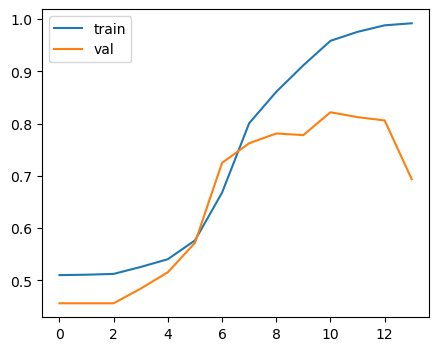

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.6425 - loss: 1.1039
test_loss:1.1038844585418701, test_acc:0.6424999833106995
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
[[0.9143943]
 [0.9257035]]


In [ ]:
# 실습4 : 실습3 결과 개선 
# 개선1. GlobalMaxPooling 사용 (파라미터 감소)
    # - Flatten 대신 GlobalMaxPooling1D 각 필터의 최대값만 추출해서 파라미터 수를 감소
    # - 토크나이저 - 시퀀스 - 패딩 ===>  X값 / label ===> y값
    # - 분할



import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  #단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences  # 길이 맞추길

# nltk 데이터로드
import nltk
nltk.download('movie_review')
from nltk.corpus import movie_reviews

# 재현성 시드 고정
import random
SEED  =42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 데이터로딩
ids = movie_reviews.fileids()  #영화리뷰 txt파일
reviews=[movie_reviews.raw(id) for id in ids]
categories =[ movie_reviews.categories(id)[0] for id in ids]
categories[:3], reviews[:3]



# 하이퍼파라미터 :# 최대단어수, 문서길이, 임베딩차원, batch_size, epoch
max_words= 10000 # 최대단어수
maxlen = 500 #문서길이
embed_dim = 64 #임베딩차원
batch_size=256 #batch_size
epochs = 14 #epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words, oov_token="UNK")
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x, maxlen=maxlen, truncating='post')
                                # padding : 길이가 짧을 때 채움 / 앞에서 채울지, 뒤에서 채울지
                                # truncating : 길이가 길때 짜름/ 앞 or 뒤

# 라벨인코딩
label_map = {'pos':0, 'neg':1}
y= np.array([label_map.get(c) for c in categories])

# train/test 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

############################ 상기도 기존과 동일하고
############## 하기 모델에서 GlobalAvgPool 하고 그뒤 Maxpool, Flatten 미실행
# 모델 구성
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_words, output_dim=embed_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPool1D(),  # MaxPpool : 시퀀스의 구간별로 최대값만 출력/시퀀스 구간별 특징을 요약
        tf.keras.layers.Conv1D(256, 3, activation='relu'),
        tf.keras.layers.GlobalAvgPool1D(),  
                    # GlobalAvgPool1D : 전체시퀀스의 평균 출력 / 시퀀스 차원을 없애고 채널 축만 남김?????(채널에 대한 평균)  --> 데이터가 1차원형태로 펴져서 flatten 할필요없음
        # tf.keras.layers.MaxPool1D(),
        # tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
            
############################하기는 기존과 동일
# 컴파일
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

# 콜백 (선택사항) (early stopping)
es = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

# 학습 
history = model.fit(
    x_train,y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2
#     , callbacks=[es]
)


# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 상기 출력결과... 시간이 지날수록 train 과 val의 차이가 커짐 --> 과적합 커짐

# 테스트 평가
test_loss, test_acc=model.evaluate(x_test,y_test)
print (f'test_loss:{test_loss}, test_acc:{test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]

## 임의의 데이터 시퀀스 변화
x_temp_test = tokenizer.texts_to_sequences(sample_texts)
x_temp_test = pad_sequences(x_temp_test, maxlen=maxlen, truncating='post')
temp_preds = model.predict(x_temp_test)
print(temp_preds)

<span style="font-size:12px">
---------------------------------------------------------------

#### 개선1
- Flatten 대신 GlobalMaxPooling 사용 (파라미터 감소)
- EarlyStopping(patience=7
- epochs = 15 #epoch


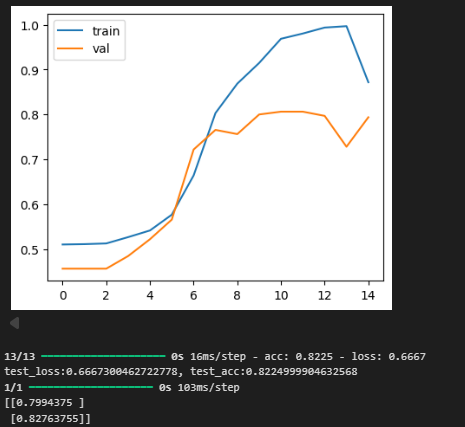

<span style="font-size:12px">
---------------------------------------------------------------

#### 개선2 : 다중 커널 크기 병렬 적용(TextCNN)
    - 커널크기 3 5 7 동시에 사용. 다양한 3-gram 5-gram 7-gram 포착

[nltk_data] Error loading movie_review: Package 'movie_review' not
[nltk_data]     found in index


Epoch 1/40


c:\Users\playdata2\miniconda3\envs\LLM\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 521ms/step - acc: 0.5031 - loss: 0.6932 - val_acc: 0.5000 - val_loss: 0.6937
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 476ms/step - acc: 0.5281 - loss: 0.6901 - val_acc: 0.5063 - val_loss: 0.6908
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 496ms/step - acc: 0.5367 - loss: 0.6873 - val_acc: 0.5125 - val_loss: 0.6889
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - acc: 0.5422 - loss: 0.6816 - val_acc: 0.5188 - val_loss: 0.6842
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - acc: 0.5719 - loss: 0.6678 - val_acc: 0.5719 - val_loss: 0.6710
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - acc: 0.6445 - loss: 0.6401 - val_acc: 0.7281 - val_loss: 0.6420
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - acc: 0.7859 - loss: 0.5849 - val_acc: 0.7281 - val_loss: 0.5926
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step - acc: 0.8297 - loss: 0.4996 - val_acc: 0.7469 - val_loss: 0.5432
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 508ms/step - acc: 0.8633 - loss: 0.4072 - va

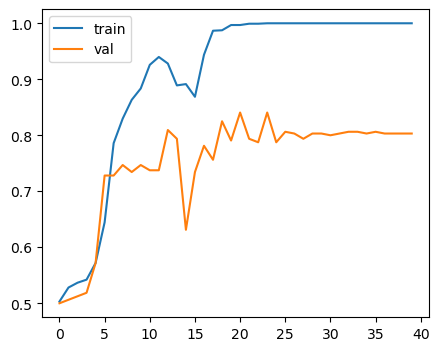

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8475 - loss: 0.4827
test_loss:0.48266541957855225, test_acc:0.8475000262260437
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
[[0.91343373]
 [0.94362926]]


In [26]:
#### 개선2 : 다중 커널 크기 병렬 적용(TextCNN)


import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  #단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences  # 길이 맞추길

# nltk 데이터로드
import nltk
nltk.download('movie_review')
from nltk.corpus import movie_reviews

# 재현성 시드 고정
import random
SEED  =42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 데이터로딩
ids = movie_reviews.fileids()  #영화리뷰 txt파일
reviews=[movie_reviews.raw(id) for id in ids]
categories =[ movie_reviews.categories(id)[0] for id in ids]
categories[:3], reviews[:3]



# 하이퍼파라미터 :# 최대단어수, 문서길이, 임베딩차원, batch_size, epoch
max_words= 10000 # 최대단어수
maxlen = 500 #문서길이
embed_dim = 64 #임베딩차원
batch_size=256 #batch_size
epochs = 40 #epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words, oov_token="UNK")
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x, maxlen=maxlen, truncating='post')
                                # padding : 길이가 짧을 때 채움 / 앞에서 채울지, 뒤에서 채울지
                                # truncating : 길이가 길때 짜름/ 앞 or 뒤

# 라벨인코딩
label_map = {'pos':0, 'neg':1}
y= np.array([label_map.get(c) for c in categories])

# train/test 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

############################ 상기도 기존과 동일하고

#########################################################################



from tensorflow.keras.layers import Input, Concatenate
# 입력레이어
input_layer = Input(shape=(maxlen , ), dtype='int32')
# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1, embed_dim, input_length=maxlen)(input_layer)
conv_blocks = []
for kenel_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(128, kenel_size, activation='relu')(embedding)
    pool = tf.keras.layers.GlobalAvgPool1D()(conv)
    conv_blocks.append(pool)
# 병렬 브랜치 결합
concat = Concatenate()(conv_blocks)
# 완전 연결층 (fc??)
dense = tf.keras.layers.Dense(64, activation='relu')(concat)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

# 모델 생성
model = tf.keras.models.Model(inputs=input_layer, outputs=output)

#########################################################################

#########################################################################
# 하기는 기존과 동일
# 컴파일
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

# 콜백 (선택사항) (early stopping)
es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# 학습 
history = model.fit(
    x_train,y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2
#     , callbacks=[es]
)


# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 상기 출력결과... 시간이 지날수록 train 과 val의 차이가 커짐 --> 과적합 커짐

# 테스트 평가
test_loss, test_acc=model.evaluate(x_test,y_test)
print (f'test_loss:{test_loss}, test_acc:{test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]

## 임의의 데이터 시퀀스 변화
x_temp_test = tokenizer.texts_to_sequences(sample_texts)
x_temp_test = pad_sequences(x_temp_test, maxlen=maxlen, truncating='pre')
temp_preds = model.predict(x_temp_test)
print(temp_preds)

<span style="font-size:12px">
----------------------------------

#### Pretrained Embeddings (GloVe) 로 초기화



|구분|Word2Vec|GloVe
|------|-------|--------------|
|학습방식|예측기반(Predictive)|통계기반(Count-based)|
|핵심아이디어 | 단어 주변 문맥 예측|단어 간 동시 출현 확률(전체 코퍼스 통계) 사용|
|대표모델|Skip-Gram, CBOW|Global Vectors(GloVe)|

In [ ]:
#### Pretrained Embedding (GloVe)
# 즉, “왜 갑자기 GloVe를 사용하냐?”
# 목적: 단어 벡터를 사전 학습된 값으로 초기화해서 학습 성능 향상
# CNN 모델 구조 자체는 그대로 둬도, 임베딩 초기값만 바꾸는 것

import os
import urllib.request
import zipfile
glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'
glove_dir = './glove_data'
glove_file = os.path.join(glove_dir, 'glove.6B.100d.txt')

if not os.path.exists(glove_file):
    os.makedirs(glove_dir, exist_ok=True)
    zip_path = os.path.join(glove_dir, 'glove.6B.zip')
    urllib.request.urlretrieve(glove_url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)
    print("다운로드 완료!")

다운로드 완료!


In [39]:
import gensim.downloader as api
import numpy as np
# Glove모델 (50차원)
wv = api.load('glove-wiki-gigaword-50')

In [ ]:
# 우리 데이터셋에서 사용되는 단어들을 GloVe가 이미 학습한 벡터로 연결해서
# Embedding Layer 의 가중치 초기값으로 사용하기 위해 embedding_matrix를 만드는 것.
wv['king'].shape

(50,)

[nltk_data] Error loading movie_review: Package 'movie_review' not
[nltk_data]     found in index


매칭 : 9722, 비매칭: 277
 커버리지 : 0.9722972297229723
Epoch 1/14


c:\Users\playdata2\miniconda3\envs\LLM\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 534ms/step - acc: 1.0000 - loss: 9.9193e-05 - val_acc: 0.8188 - val_loss: 0.7717
Epoch 2/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 525ms/step - acc: 1.0000 - loss: 9.9729e-05 - val_acc: 0.8000 - val_loss: 0.7505
Epoch 3/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - acc: 1.0000 - loss: 5.6216e-05 - val_acc: 0.7906 - val_loss: 1.0072
Epoch 4/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 752ms/step - acc: 1.0000 - loss: 6.1120e-05 - val_acc: 0.7969 - val_loss: 0.8160
Epoch 5/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 701ms/step - acc: 1.0000 - loss: 2.3468e-05 - val_acc: 0.7937 - val_loss: 0.8755
Epoch 6/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step - acc: 1.0000 - loss: 1.6122e-05 - val_acc: 0.8062 - val_loss: 0.8238
Epoch 7/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 879ms/step - acc: 1.0000 - loss: 1.0339e-05 - val_acc: 0.7969 - val_loss: 0.9344
Epoch 8/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 799ms/step - acc: 1.0000 - loss: 9.3456e-06 - val_acc: 0.7937 - val_loss: 0.8911
Epoch 9/14
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 753ms/step -

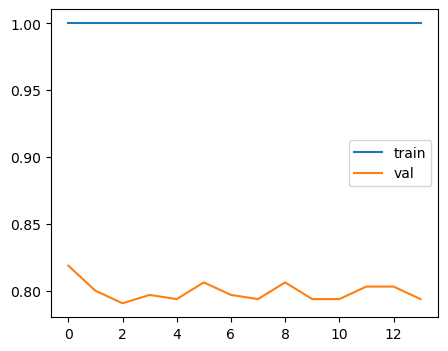

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.8450 - loss: 0.8505
test_loss:0.8504907488822937, test_acc:0.8450000286102295
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
[[0.9968126]
 [0.9987322]]


In [ ]:
##### 실습5. 기존에 만들어진 embedding을 가져와서 실행
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  #단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences  # 길이 맞추길

# nltk 데이터로드
import nltk
nltk.download('movie_review')
from nltk.corpus import movie_reviews

# 재현성 시드 고정
import random
SEED  =42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 데이터로딩
ids = movie_reviews.fileids()  #영화리뷰 txt파일
reviews=[movie_reviews.raw(id) for id in ids]
categories =[ movie_reviews.categories(id)[0] for id in ids]
categories[:3], reviews[:3]



# 하이퍼파라미터 
max_words= 10000 # 최대단어수
maxlen = 500 #문서길이
embed_dim = 50 #임베딩차원
batch_size=256 #batch_size
epochs = 14 #epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words, oov_token="UNK")
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x, maxlen=maxlen, truncating='post')
                                # padding : 길이가 짧을 때 채움 / 앞에서 채울지, 뒤에서 채울지
                                # truncating : 길이가 길때 짜름/ 앞 or 뒤

# 라벨인코딩
label_map = {'pos':0, 'neg':1}
y= np.array([label_map.get(c) for c in categories])

# train/test 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)


##################################################### 상기는 기존과 동일
#####################################################

# 임베딩 매트릭스 초기화
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index)+1)
embedding_matrix = np.random.normal(
    loc=0.0, scale=0.1, size=(num_words, embed_dim)
)

# 임베딩: glove 매칭 --> glove 미리 만들어진 임베딩..?
hits = 0
misses = 0
for word, i in word_index.items():
    if i >= max_words:
        continue
    try:
        embedding_vector = wv[word]   # GloVe에서 단어 벡터 찾기
        embedding_matrix[i] = embedding_vector # 해당 위치에 저장
        hits += 1
    except KeyError:
        misses += 1
print(f'매칭 : {hits}, 비매칭: {misses}')
print(f' 커버리지 : {hits / (hits+misses)}')

tf.keras.models.Sequential([
    tf.keras.layers.Embedding(num_words, output_dim=embed_dim, input_length=maxlen,
                              weights=[embedding_matrix]),

##################################################### 
    ##################################################### 하기는 기존과 동일
                              
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool1D(),  # MaxPpool : 시퀀스의 구간별로 최대값만 출력/시퀀스 구간별 특징을 요약
    tf.keras.layers.Conv1D(256, 3, activation='relu'),
    tf.keras.layers.GlobalAvgPool1D(),  
                # GlobalAvgPool1D : 전체시퀀스의 평균 출력 / 시퀀스 차원을 없애고 채널 축만 남김?????(채널에 대한 평균)  --> 데이터가 1차원형태로 펴져서 flatten 할필요없음
    # tf.keras.layers.MaxPool1D(),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# 컴파일
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

# 콜백 (선택사항) (early stopping)
es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# 학습 
history = model.fit(
    x_train,y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2
#     , callbacks=[es]
)


# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 상기 출력결과... 시간이 지날수록 train 과 val의 차이가 커짐 --> 과적합 커짐

# 테스트 평가
test_loss, test_acc=model.evaluate(x_test,y_test)
print (f'test_loss:{test_loss}, test_acc:{test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]

## 임의의 데이터 시퀀스 변화
x_temp_test = tokenizer.texts_to_sequences(sample_texts)
x_temp_test = pad_sequences(x_temp_test, maxlen=maxlen, truncating='pre')
temp_preds = model.predict(x_temp_test)
print(temp_preds)

### >> 실습 6 : 다중 커널 (3 5 7) + 드랍아웃 + L2정규화

[nltk_data] Error loading movie_review: Package 'movie_review' not
[nltk_data]     found in index


Epoch 1/40


c:\Users\playdata2\miniconda3\envs\LLM\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step - acc: 0.5117 - loss: 1.0364 - val_acc: 0.4563 - val_loss: 1.0058
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 484ms/step - acc: 0.5250 - loss: 0.9808 - val_acc: 0.4875 - val_loss: 0.9541
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 471ms/step - acc: 0.5312 - loss: 0.9323 - val_acc: 0.5188 - val_loss: 0.9090
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - acc: 0.5375 - loss: 0.8904 - val_acc: 0.5125 - val_loss: 0.8712
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 470ms/step - acc: 0.5430 - loss: 0.8528 - val_acc: 0.5094 - val_loss: 0.8390
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - acc: 0.5484 - loss: 0.8219 - val_acc: 0.5156 - val_loss: 0.8111
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 582ms/step - acc: 0.5602 - loss: 0.7892 - val_acc: 0.5344 - val_loss: 0.7843
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 645ms/step - acc: 0.6078 - loss: 0.7554 - val_acc: 0.6281 - val_loss: 0.7527
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 608ms/step - acc: 0.6930 - loss: 0.7104 - va

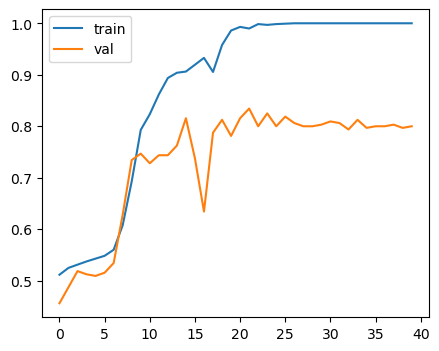

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.8375 - loss: 0.4713
test_loss:0.47134727239608765, test_acc:0.8374999761581421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
[[0.7990963 ]
 [0.82504797]]


In [ ]:


import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  #단어를 단어사전, 단어를 숫자로 변경
from tensorflow.keras.preprocessing.sequence import pad_sequences  # 길이 맞추길

# nltk 데이터로드
import nltk
nltk.download('movie_review')
from nltk.corpus import movie_reviews

# 재현성 시드 고정
import random
SEED  =42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# 데이터로딩
ids = movie_reviews.fileids()  #영화리뷰 txt파일
reviews=[movie_reviews.raw(id) for id in ids]
categories =[ movie_reviews.categories(id)[0] for id in ids]
categories[:3], reviews[:3]



# 하이퍼파라미터 :# 최대단어수, 문서길이, 임베딩차원, batch_size, epoch
max_words= 10000 # 최대단어수
maxlen = 500 #문서길이
embed_dim = 64 #임베딩차원
batch_size=256 #batch_size
epochs = 40 #epoch

# 토큰화 + 시퀀스변화 + 패딩
tokenizer = Tokenizer(num_words=max_words, oov_token="UNK")
tokenizer.fit_on_texts(reviews)
x = tokenizer.texts_to_sequences(reviews)
x = pad_sequences(x, maxlen=maxlen, truncating='post')
                                # padding : 길이가 짧을 때 채움 / 앞에서 채울지, 뒤에서 채울지
                                # truncating : 길이가 길때 짜름/ 앞 or 뒤

# 라벨인코딩
label_map = {'pos':0, 'neg':1}
y= np.array([label_map.get(c) for c in categories])

# train/test 분할
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

############################ 상기도 기존과 동일하고

#########################################################################



from tensorflow.keras.layers import Input, Concatenate
# 입력레이어
input_layer = Input(shape=(maxlen , ), dtype='int32')
# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1, embed_dim, input_length=maxlen)(input_layer)
conv_blocks = []
for kenel_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(128, kenel_size, activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(1e-3) # 정규화추가
                                    )(embedding)
    pool = tf.keras.layers.GlobalAvgPool1D()(conv)
    conv_blocks.append(pool)
# 병렬 브랜치 결합
concat = Concatenate()(conv_blocks)
# 완전 연결층 (fc??)
dense = tf.keras.layers.Dense(128,activation='relu',  # 128로 수정
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)  # 정규화추가
                              )(concat) 
dense = tf.keras.layers.Dropout(0.5)(dense) # Dropout 추가 -- 과적합 방지
dense = tf.keras.layers.Dense(64,activation='relu',    # dropout을 추가하기위해 dense 층도 추가
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)  # 정규화추가
                              )(concat) 
dense = tf.keras.layers.Dropout(0.3)(dense) # Dropout 추가 -- 과적합 방지
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

# 모델 생성
model = tf.keras.models.Model(inputs=input_layer, outputs=output)


#########################################################################

#########################################################################
# 하기는 기존과 동일
# 컴파일
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])

# 콜백 (선택사항) (early stopping)
es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# 학습 
history = model.fit(
    x_train,y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2
#     , callbacks=[es]
)


# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 상기 출력결과... 시간이 지날수록 train 과 val의 차이가 커짐 --> 과적합 커짐

# 테스트 평가
test_loss, test_acc=model.evaluate(x_test,y_test)
print (f'test_loss:{test_loss}, test_acc:{test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]

## 임의의 데이터 시퀀스 변화
x_temp_test = tokenizer.texts_to_sequences(sample_texts)
x_temp_test = pad_sequences(x_temp_test, maxlen=maxlen, truncating='pre')
temp_preds = model.predict(x_temp_test)
print(temp_preds)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 862ms/step - acc: 0.5000 - loss: 1.0429 - val_acc: 0.4563 - val_loss: 1.0174
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 816ms/step - acc: 0.5891 - loss: 0.9841 - val_acc: 0.5281 - val_loss: 0.9691
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 774ms/step - acc: 0.7789 - loss: 0.9388 - val_acc: 0.5437 - val_loss: 0.9311
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 761ms/step - acc: 0.8047 - loss: 0.8968 - val_acc: 0.4563 - val_loss: 0.8994
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 773ms/step - acc: 0.7563 - loss: 0.8611 - val_acc: 0.4563 - val_loss: 0.8712
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 792ms/step - acc: 0.8164 - loss: 0.8288 - val_acc: 0.4594 - val_loss: 0.8467
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 759ms/step - acc: 0.9008 - loss: 0.7982 - val_acc: 0.4906 - val_loss: 0.8252
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 767ms/step - acc: 0.9305 - loss: 0.7720 - val_acc: 0.5469 - val_loss: 0.8066
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 778ms/step - acc: 0.9438 - loss: 

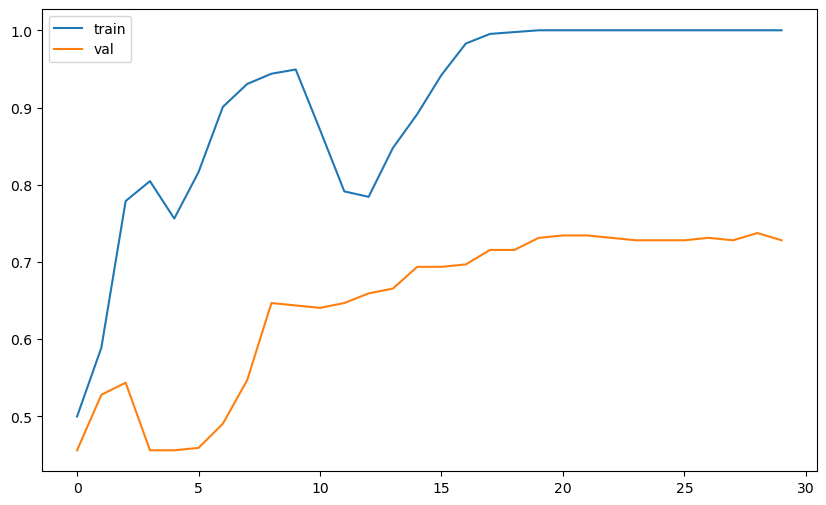

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.7325 - loss: 0.6787
test loss : 0.6787420511245728  test acc : 0.7325000166893005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


array([[0.21969612],
       [0.46445844]], dtype=float32)

In [ ]:
#########################################  강사님 코드 붙여넣기해서 비교.. 근데 예측 잘나옴.. 왜징??!! 랜덤시드떄문..! 

from tensorflow.keras.layers import Input, Concatenate
# 입력레이어
input_layer = Input(shape=(maxlen ,) ,dtype='int32')
# 임베딩 레이어
embedding = tf.keras.layers.Embedding(max_words+1,embed_dim, input_length = maxlen )(input_layer)
conv_blocks = []
for kener_size in [3,5,7]:
    conv = tf.keras.layers.Conv1D(
                128,
                kener_size,activation='relu',
                kernel_regularizer=tf.keras.regularizers.l2(1e-3) # 정규화추가
                )(embedding) 
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)
    conv_blocks.append(pool)
# 병렬 브랜치 결합
concat = Concatenate()(conv_blocks)
# 완전연결층
dense = tf.keras.layers.Dense(128,activation='relu',  # 128로 수정
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)  # 정규화추가
                              )(concat) 
dense = tf.keras.layers.Dropout(0.5)(dense) # Dropout 추가 -- 과적합 방지
dense = tf.keras.layers.Dense(64,activation='relu',    # dropout을 추가하기위해 dense 층도 추가
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)  # 정규화추가
                              )(concat) 
dense = tf.keras.layers.Dropout(0.3)(dense) # Dropout 추가 -- 과적합 방지
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

#모델 생성
model = tf.keras.models.Model(inputs = input_layer, outputs = output)

# 컴파일
adam =  tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['acc'])
# 콜백(선택)
import tensorflow as  tf
es = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# 학습
history = model.fit(
    x_train,y_train,epochs=30,batch_size=batch_size,validation_split = 0.2
    # ,callbacks=[es]
)

# 학습결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(history.history['acc'],label='train')
plt.plot(history.history['val_acc'], label='val')
plt.legend()
plt.show()
# 테스트 평가
test_loss,  test_acc =  model.evaluate(x_test,y_test)
print(f'test loss : {test_loss}  test acc : {test_acc}')

# 임의의 데이터로 예측
sample_texts = [
    "This movie was absolutely fantastic and inspiring",
    "I really disliked the plot and the acting was terrible"
]
x_sample = tokenizer.texts_to_sequences(sample_texts)
x_sample = pad_sequences(x_sample,maxlen=maxlen,truncating='post')
x_sample_predict = model.predict(x_sample)
x_sample_predict

<span style="font-size:12px">

#### 감성 분석용 말뭉치
https://github.com/bab2min/corpus/tree/master/sentiment


- naver_shopping.txt
- 언어: 한국어
- 출처: 네이버 쇼핑 (https://shopping.naver.com/)
- 수집 기간: 2020.06~2020.07
- 데이터 건수: 20만 건
- 네이버 쇼핑에서 제품별 후기를 별점과 함께 수집한 것입니다. 데이터는 탭으로 분리되어 있으며, 첫번째 - 필드에는 별점(1 ~ 5), 두번째 필드에는 텍스트가 위치합니다. 긍/부정으로 분류하기 애매한 3점에 해당하는 텍스트들은 제외하였고, 긍정(4 ~ 5점)과 부정(1 ~ 2점)의 비율이 1:1에 가깝도록 샘플링하였습니다.

<br>

- steam.txt
- 언어: 한국어
- 출처: Steam (https://store.steampowered.com/)
- 수집 기간: 2020.05~2020.06
- 데이터 건수: 10만 건
- 게임 유통 서비스인 Steam의 각종 게임에 달린 한국어 리뷰를 수집